Risk Prediction Using Tree-based Models
-------------------------------------------

### Project Objective
Use tree based machine learning models to predict the 10-year risk of death of individuals from the NHANES epidemiology dataset

The following key concepts are covered here
* Dealing with missing data
    * Complete case analysis
    * Imputation
* Decision Trees
    * Evaluation
    * Regularization
* Random Forests
    * Hyperparameter Tuning

### Import Packages

In [17]:
import shap
import sklearn
import itertools
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import os
import lifelines

from IPython.display import Image 

from six import StringIO
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

%config Completer.use_jedi = False

### Load Dataset and Preprocess

In [2]:
X = pd.read_csv('Data/NHANESI_subset_X.csv')

# y is the survival time data. Positive numbers indicate time period of death
# Negative numbers mean death=False
y = pd.read_csv('Data/NHANESI_subset_y.csv')['y']
y = np.array(y)

threshold = 10

df = X.drop([X.columns[0]], axis=1)

# extract data between +/- 10
df.loc[:, 'time'] = y
df.loc[:, 'death'] = np.ones(len(X))
df.loc[df.time < 0, 'death'] = 0
df.loc[:, 'time'] = np.abs(df.time)

df = df.dropna(axis='rows')

# cond1: dead or alive for more than 10 years
# cond2: dead
# final: dead irrespective of time or alive for more than 10 years
# remove people who are alive and below the threshold
mask = (df.time > threshold) | (df.death == 1)
df = df[mask]
X = df.drop(['time', 'death'], axis='columns')

# predicting 10 year death risk
# if dead in under 10 years, y = TRUE
# if dead in over 10 years or alive, y = FALSE
y = df.time < threshold    

In [3]:
# intentionally setting systolic BP for a certain population to NaN
def prob_drop(age):
    return 1 - (np.exp(0.25 * age - 5) / (1 + np.exp(0.25 * age - 5)))

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
feature_y = 'Systolic BP'
frac = 0.7

drop_rows = X_dev.sample(frac=frac, replace=False,
                         weights=[prob_drop(X_dev.loc[i, 'Age']) for i in
                                  X_dev.index], random_state=10)

X_dev.loc[drop_rows.index, feature_y] = None

# 75/25 test validation split
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=10)

### Exploratory Data Analysis

In [4]:
print("X_train shape: {}".format(X_train.shape))
X_train.head()

X_train shape: (5147, 18)


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
1599,43.0,84.0,637.0,1.0,49.3,10.0,5.0,253.0,134.0,1.59,7.7,1.0,NaN,490.0,27.3,9.1,25.803007,34.0
2794,72.0,96.0,154.0,2.0,43.4,23.0,4.3,265.0,106.0,1.66,6.8,2.0,208.0,301.0,35.2,6.0,33.394319,112.0
1182,54.0,78.0,205.0,1.0,43.8,12.0,4.2,206.0,180.0,1.67,6.6,2.0,NaN,363.0,49.6,5.9,20.278410,34.0
6915,59.0,90.0,417.0,1.0,43.4,9.0,4.5,327.0,114.0,1.65,7.6,2.0,NaN,347.0,32.9,6.1,32.917744,78.0
500,34.0,80.0,385.0,1.0,77.7,9.0,4.1,197.0,64.0,1.74,7.3,2.0,NaN,376.0,17.0,8.2,30.743489,30.0


In [5]:
y_train.head(20)

1599    False
2794     True
1182    False
6915    False
500     False
1188     True
9739    False
3266    False
6681    False
8822    False
5856     True
3415    False
9366    False
7975    False
1397    False
6809    False
9461    False
9374    False
1170     True
158     False
Name: time, dtype: bool

#### Individual Patient Record

In [6]:
i = 25
print(X_train.iloc[i,:])
print("\nDied within 10 years? {}".format(y_train.loc[y_train.index[i]]))

Age                    73.000000
Diastolic BP           88.000000
Poverty index          68.000000
Race                    2.000000
Red blood cells        42.100000
Sedimentation rate     19.000000
Serum Albumin           3.600000
Serum Cholesterol     215.000000
Serum Iron             64.000000
Serum Magnesium         1.590000
Serum Protein           5.700000
Sex                     2.000000
Systolic BP           190.000000
TIBC                  334.000000
TS                     19.200000
White blood cells       6.600000
BMI                    31.880432
Pulse pressure        102.000000
Name: 7331, dtype: float64

Died within 10 years? True


#### Summary Statistics

In [9]:
perc = [0.2,0.4,0.6,0.8]
include =['object', 'float', 'int']
X_train.describe(percentiles=perc, include = include)

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
count,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,1551.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000
mean,49.312804,83.007577,289.225957,1.191374,51.975189,15.926948,4.372897,221.468895,101.650865,1.683056,7.108102,1.606761,149.781431,363.318827,28.623548,7.445697,25.660070,51.459491
std,15.821797,13.157723,221.885516,0.426597,11.757915,11.316444,0.329408,49.220442,37.850165,0.145673,0.497579,0.488517,25.602783,57.657532,11.307506,2.235903,5.035472,18.352268
min,25.000000,38.000000,2.000000,1.000000,25.500000,1.000000,2.900000,53.000000,17.000000,0.820000,4.800000,1.000000,90.000000,168.000000,3.200000,2.100000,14.499821,10.000000
20%,32.000000,72.000000,118.000000,1.000000,43.900000,6.000000,4.100000,180.000000,70.000000,1.570000,6.700000,1.000000,130.000000,316.000000,19.500000,5.700000,21.540983,36.000000
40%,42.000000,80.000000,190.000000,1.000000,46.800000,11.000000,4.300000,205.000000,88.000000,1.650000,7.000000,2.000000,140.000000,344.000000,24.800000,6.700000,23.818506,44.000000
50%,48.000000,80.000000,233.000000,1.000000,48.200000,14.000000,4.400000,217.000000,96.000000,1.680000,7.100000,2.000000,148.000000,357.000000,27.300000,7.200000,24.927806,48.000000
60%,55.000000,85.000000,281.600000,1.000000,49.900000,16.000000,4.400000,229.000000,106.000000,1.720000,7.200000,2.000000,152.000000,371.000000,29.900000,7.700000,26.175576,52.000000
80%,67.000000,92.000000,409.000000,1.000000,55.300000,25.000000,4.600000,259.000000,130.000000,1.800000,7.500000,2.000000,170.000000,405.800000,36.900000,8.900000,29.241266,64.000000
max,74.000000,180.000000,999.000000,3.000000,88.800000,65.000000,5.700000,691.000000,396.000000,2.700000,9.600000,2.000000,250.000000,717.000000,100.000000,56.000000,58.818811,150.000000


#### Box and Whisker Plots

Text(0.5, 0.98, '')

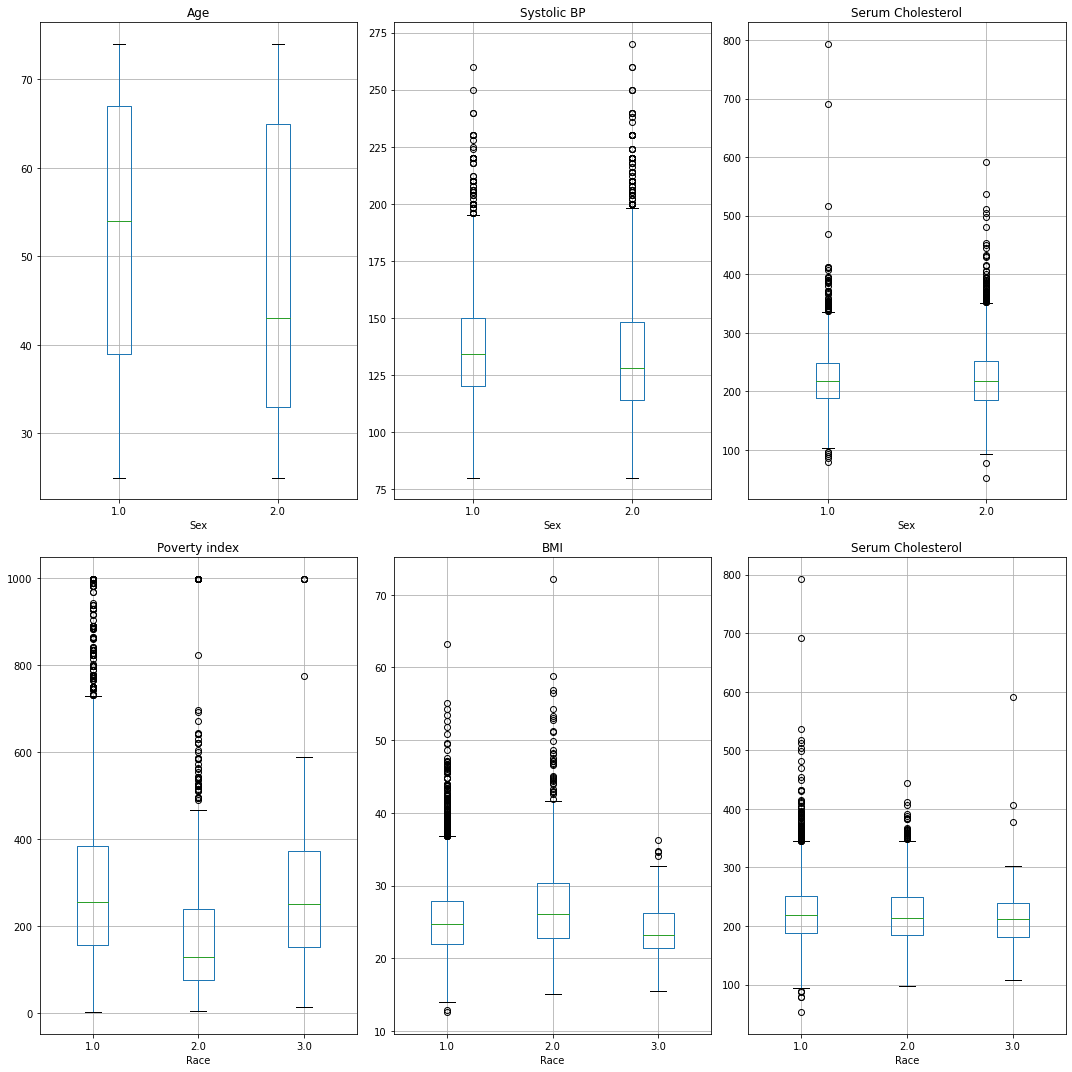

In [40]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 
fig, axes = plt.subplots(2,3,figsize=(15,15))
df.boxplot(ax=axes[0,0], column='Age',by='Sex')
df.boxplot(ax=axes[0,1], column='Systolic BP',by='Sex')
df.boxplot(ax=axes[0,2], column='Serum Cholesterol',by='Sex')
df.boxplot(ax=axes[1,0], column='Poverty index',by='Race')
df.boxplot(ax=axes[1,1], column='BMI',by='Race')
df.boxplot(ax=axes[1,2], column='Serum Cholesterol',by='Race')
plt.tight_layout()
fig.suptitle('')

#### Scatter Plots

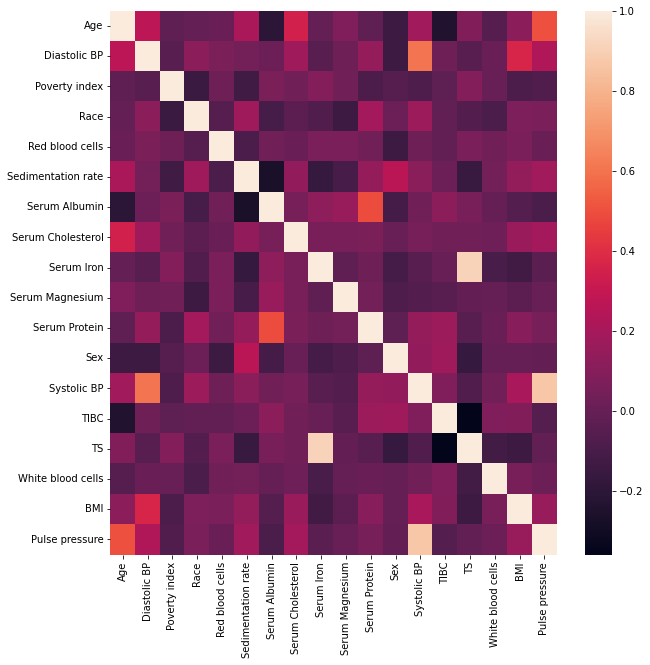

In [58]:
fig, axes = plt.subplots(figsize=(10,10))
corr = X_train.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

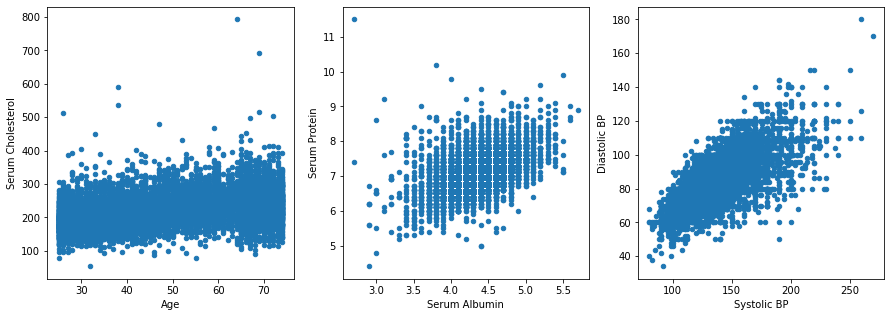

In [68]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
df.plot.scatter(ax=axes[0],x='Age',y='Serum Cholesterol')
df.plot.scatter(ax=axes[1],x='Serum Albumin',y='Serum Protein')
df.plot.scatter(ax=axes[2],x='Systolic BP',y='Diastolic BP')

### Missing Data

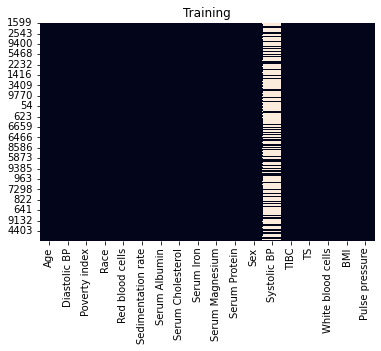

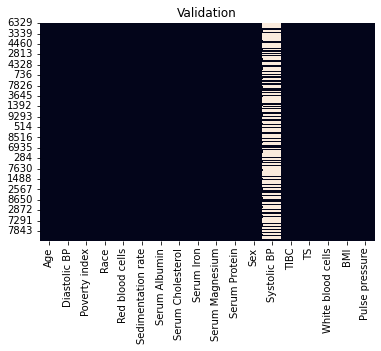

In [7]:
sns.heatmap(X_train.isnull(), cbar=False)
plt.title("Training")
plt.show()

sns.heatmap(X_val.isnull(), cbar=False)
plt.title("Validation")
plt.show()

In [72]:
def fraction_rows_missing(df):
    '''
    Return percent of rows with any missing
    data in the dataframe. 
    
    Input:
        df (dataframe): a pandas dataframe with potentially missing data
    Output:
        frac_missing (float): fraction of rows with missing data
    '''
    ### START CODE HERE (REPLACE 'Pass' with your 'return' code) ###
    return (1 - df_test.dropna().shape[0]/df.shape[0])

df_test = pd.DataFrame({'a':[None, 1, 1, None], 'b':[1, None, 0, 1]})
print("Example dataframe:\n")
print(df_test)

print("\nComputed fraction missing: {}, expected: {}".format(fraction_rows_missing(df_test), 0.75))
print(f"Fraction of rows missing from X_train: {fraction_rows_missing(X_train):.3f}")
print(f"Fraction of rows missing from X_val: {fraction_rows_missing(X_val):.3f}")
print(f"Fraction of rows missing from X_test: {fraction_rows_missing(X_test):.3f}")

Example dataframe:

     a    b
0  NaN  1.0
1  1.0  NaN
2  1.0  0.0
3  NaN  1.0

Computed fraction missing: 0.75, expected: 0.75
Fraction of rows missing from X_train: 1.000
Fraction of rows missing from X_val: 0.999
Fraction of rows missing from X_test: 0.999


### Complete Case Analysis

In [73]:
# drop all rows with any missing data
X_train_dropped = X_train.dropna(axis='rows')
y_train_dropped = y_train.loc[X_train_dropped.index]
X_val_dropped = X_val.dropna(axis='rows')
y_val_dropped = y_val.loc[X_val_dropped.index]

X_train_dropped

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
2794,72.0,96.0,154.0,2.0,43.4,23.0,4.3,265.0,106.0,1.66,6.8,2.0,208.0,301.0,35.2,6.0,33.394319,112.0
5856,67.0,94.0,114.0,1.0,43.8,12.0,3.7,178.0,73.0,1.85,7.0,1.0,140.0,311.0,23.5,4.3,17.481227,46.0
9374,68.0,80.0,201.0,1.0,46.2,20.0,4.1,223.0,204.0,1.54,7.2,1.0,140.0,275.0,74.2,17.2,20.690581,60.0
8819,68.0,80.0,651.0,1.0,47.7,16.0,4.3,178.0,168.0,1.97,7.3,1.0,102.0,339.0,49.6,10.2,27.719091,22.0
7331,73.0,88.0,68.0,2.0,42.1,19.0,3.6,215.0,64.0,1.59,5.7,2.0,190.0,334.0,19.2,6.6,31.880432,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8780,67.0,84.0,103.0,1.0,44.6,7.0,4.5,157.0,82.0,1.46,7.1,2.0,160.0,341.0,24.0,6.8,25.792687,76.0
1831,67.0,88.0,198.0,1.0,49.6,18.0,4.3,237.0,92.0,1.72,6.9,1.0,170.0,404.0,22.8,6.5,28.479061,82.0
6169,68.0,86.0,242.0,2.0,38.3,33.0,4.2,135.0,140.0,1.77,7.6,1.0,168.0,352.0,39.8,7.1,21.986694,82.0
2547,67.0,104.0,46.0,1.0,47.0,32.0,4.4,324.0,64.0,1.63,7.5,1.0,162.0,347.0,18.4,5.2,33.105158,58.0


### Concordance Index

In [74]:
def cindex(y_true, scores):
    return lifelines.utils.concordance_index(y_true, scores)

### Decision Tree (baseline)

In [75]:
dt = DecisionTreeClassifier(max_depth=None, random_state=10)
dt.fit(X_train_dropped, y_train_dropped)

y_train_preds = dt.predict_proba(X_train_dropped)[:, 1]
print(f"Train C-Index: {cindex(y_train_dropped.values, y_train_preds)}")

y_val_preds = dt.predict_proba(X_val_dropped)[:, 1]
print(f"Val C-Index: {cindex(y_val_dropped.values, y_val_preds)}")

Train C-Index: 1.0
Val C-Index: 0.5629321808510638


### Decision Tree (tuned)

In [76]:
dt_hyperparams = {'min_samples_split':0.2,
                  'max_depth':3
                 }

dt_reg = DecisionTreeClassifier(**dt_hyperparams, random_state=10)
dt_reg.fit(X_train_dropped, y_train_dropped)

y_train_preds = dt_reg.predict_proba(X_train_dropped)[:, 1]
print(f"Train C-Index: {cindex(y_train_dropped.values, y_train_preds)}")

y_val_preds = dt_reg.predict_proba(X_val_dropped)[:, 1]
print(f"Val C-Index: {cindex(y_val_dropped.values, y_val_preds)}")

Train C-Index: 0.6780135398312158
Val C-Index: 0.6247340425531915


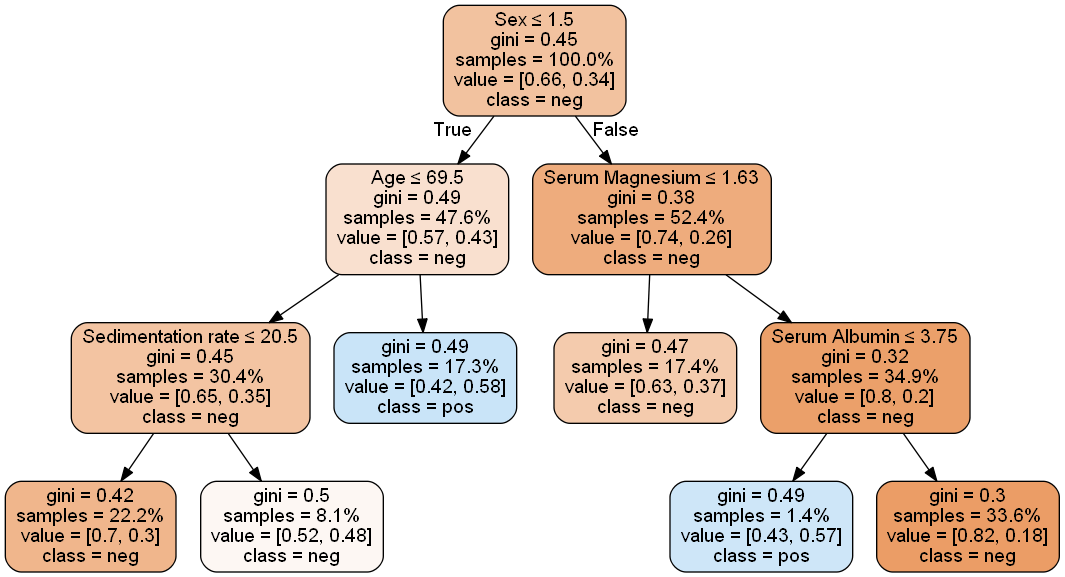

In [77]:
dot_data = StringIO()
export_graphviz(dt_reg, feature_names=X_train_dropped.columns, out_file=dot_data,  
                filled=True, rounded=True, proportion=True, special_characters=True,
                impurity=True, class_names=['neg', 'pos'], precision=2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Random Forests

In [78]:
rf = RandomForestClassifier(n_estimators=100, random_state=10)
rf.fit(X_train_dropped, y_train_dropped)

RandomForestClassifier(random_state=10)

In [79]:
y_train_rf_preds = rf.predict_proba(X_train_dropped)[:, 1]
print(f"Train C-Index: {cindex(y_train_dropped.values, y_train_rf_preds)}")

y_val_rf_preds = rf.predict_proba(X_val_dropped)[:, 1]
print(f"Val C-Index: {cindex(y_val_dropped.values, y_val_rf_preds)}")

Train C-Index: 1.0
Val C-Index: 0.6660488696808511


#### Holdout Grid Search

In [80]:
def holdout_grid_search(clf, X_train_hp, y_train_hp, X_val_hp, y_val_hp, hyperparams, fixed_hyperparams={}):
    '''
    Conduct hyperparameter grid search on hold out validation set. Use holdout validation.
    Hyperparameters are input as a dictionary mapping each hyperparameter name to the
    range of values they should iterate over. Use the cindex function as your evaluation
    function.
    '''
    best_estimator = None
    best_hyperparams = {}
    
    # hold best running score
    best_score = 0.0

    # get list of param values
    lists = hyperparams.values()
    
    # get all param combinations
    param_combinations = list(itertools.product(*lists))
    total_param_combinations = len(param_combinations)

    # iterate through param combinations
    for i, params in enumerate(param_combinations, 1):
        # fill param dict with params
        param_dict = {}
        for param_index, param_name in enumerate(hyperparams):
            param_dict[param_name] = params[param_index]
            
        # create estimator with specified params
        estimator = clf(**param_dict, **fixed_hyperparams)

        # fit estimator
        estimator.fit(X_train_hp, y_train_hp)
        
        # get predictions on validation set
        preds = estimator.predict_proba(X_val_hp)
        
        # compute cindex for predictions
        estimator_score = cindex(y_val_hp, preds[:,1])

        print(f'[{i}/{total_param_combinations}] {param_dict}')
        print(f'Val C-Index: {estimator_score}\n')

        # if new high score, update high score, best estimator
        # and best params 
        if estimator_score >= best_score:
                best_score = estimator_score
                best_estimator = estimator
                best_hyperparams = param_dict

    # add fixed hyperparamters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)
    
    return param_combinations, best_estimator, best_hyperparams

In [81]:
def random_forest_grid_search(X_train_dropped, y_train_dropped, X_val_dropped, y_val_dropped):

    # Define ranges for the chosen random forest hyperparameters 
    hyperparams = {
        'n_estimators': [_ for _ in range(50,200,25)],        
        'max_depth': [_ for _ in range(1,100,2)],
        'min_samples_leaf': [_ for _ in range(2,10,2)],
    }

    fixed_hyperparams = {
        'random_state': 10,
    }
    
    rf = RandomForestClassifier
    combinations, best_rf, best_hyperparams = holdout_grid_search(rf, X_train_dropped, y_train_dropped,
                                                    X_val_dropped, y_val_dropped, hyperparams,
                                                    fixed_hyperparams)

    print(f"Best hyperparameters:\n{best_hyperparams}")

    y_train_best = best_rf.predict_proba(X_train_dropped)[:, 1]
    print(f"Train C-Index: {cindex(y_train_dropped, y_train_best)}")

    y_val_best = best_rf.predict_proba(X_val_dropped)[:, 1]
    print(f"Val C-Index: {cindex(y_val_dropped, y_val_best)}")
    
    # add fixed hyperparamters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)
    
    return best_rf, best_hyperparams

In [82]:
# Best hyperparameters:
# {'n_estimators': 175, 'max_depth': 3, 'min_samples_leaf': 4, 'random_state': 10}
# Train C-Index: 0.777638876008532
# Val C-Index: 0.6812832446808511
# best_rf, best_hyperparams = random_forest_grid_search(X_train_dropped, y_train_dropped, X_val_dropped, y_val_dropped)
best_rf = RandomForestClassifier(**{'n_estimators': 175, 'max_depth': 3, 'min_samples_leaf': 4, 'random_state': 10})
best_rf.fit(X_train_dropped, y_train_dropped)

RandomForestClassifier(max_depth=3, min_samples_leaf=4, n_estimators=175,
                       random_state=10)

#### Baseline Performance

In [83]:
print("Baseline Performance")

y_train_best = best_rf.predict_proba(X_train_dropped)[:, 1]
print(f"- Train C-Index: {cindex(y_train_dropped, y_train_best):.4f}")

y_val_best = best_rf.predict_proba(X_val_dropped)[:, 1]
print(f"- Val C-Index: {cindex(y_val_dropped, y_val_best):.4f}")

y_test_imp = best_rf.predict_proba(X_test)[:, 1]
print(f"- Test C-Index: {cindex(y_test, y_test_imp):.4f}")

Baseline Performance
- Train C-Index: 0.7776
- Val C-Index: 0.6813
- Test C-Index: 0.6986


### Missing Data - Distributions

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


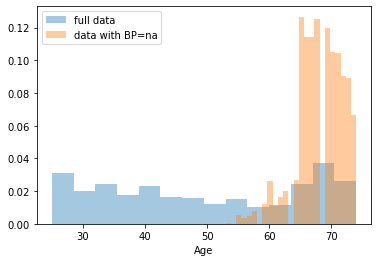

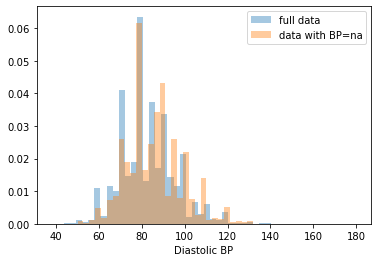

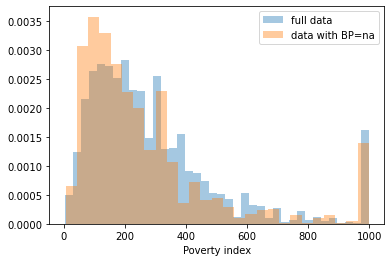

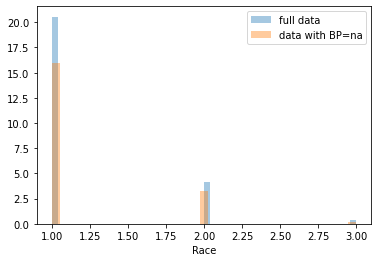

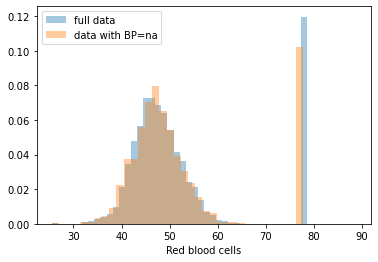

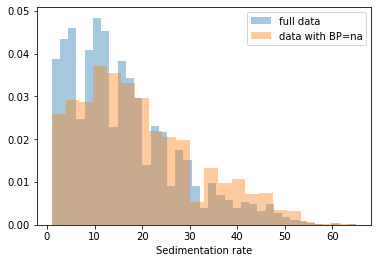

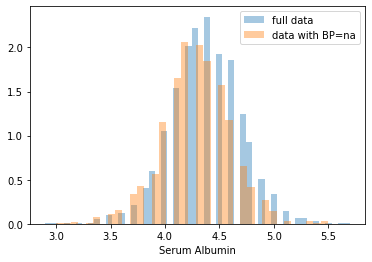

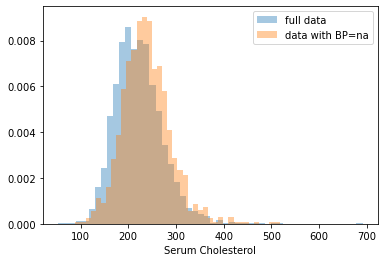

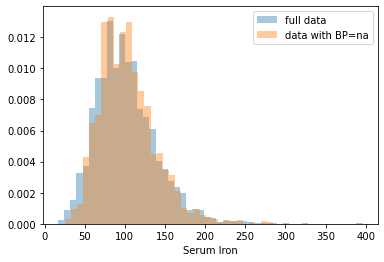

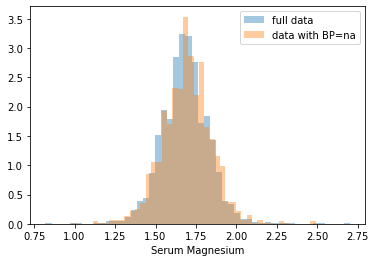

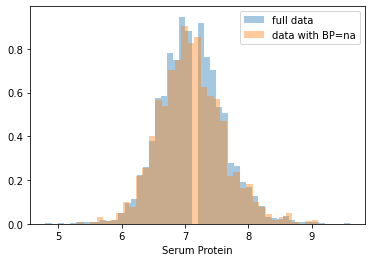

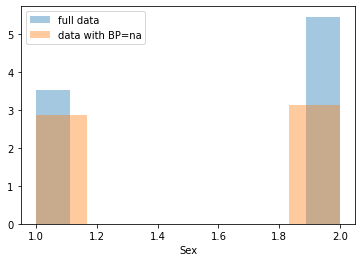

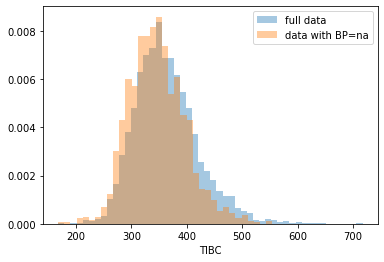

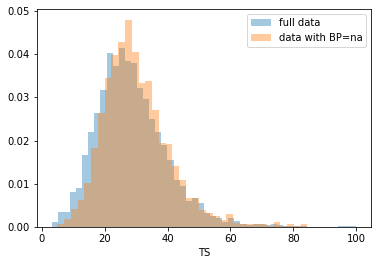

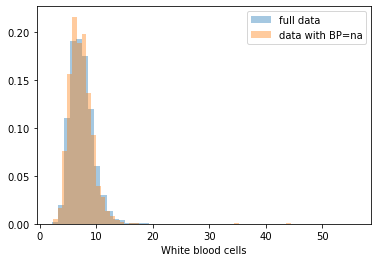

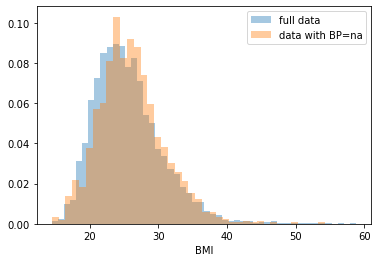

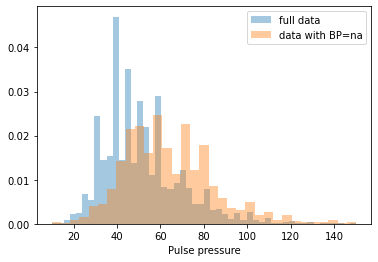

In [84]:
dropped_rows = X_train[X_train.isnull().any(axis=1)]

columns_except_Systolic_BP = [col for col in X_train.columns if col not in ['Systolic BP']]

for col in columns_except_Systolic_BP:
    sns.distplot(X_train.loc[:, col], norm_hist=True, kde=False, label='full data')
    sns.distplot(X_train_dropped.loc[:, col], norm_hist=True, kde=False, label='data with BP=na')
    plt.legend()

    plt.show()
    
# since complete case analysis changes distribution of certain variables, 

### Error Analysis

In [112]:
def bad_subset(forest, X_test, y_test):
    # define mask to select large subset with poor performance
    # for age less than 50, there is no data now. So compared to overall performance, the model is expected to perform poorly
    # in this subset. 
    mask = (X_test['Age'] < 30)
    X_subgroup = X_test[mask]
    y_subgroup = y_test[mask]
    subgroup_size = len(X_subgroup)

    y_subgroup_preds = forest.predict_proba(X_subgroup)[:, 1]
    performance = cindex(y_subgroup.values, y_subgroup_preds)
    
    return performance, subgroup_size

In [113]:
performance, subgroup_size = bad_subset(best_rf, X_test, y_test)
# print("Subgroup size should greater than 250, performance should be less than 0.69 ")
print(f"Subgroup size: {subgroup_size}, Test C-Index: {performance}")

Subgroup size: 251, Test C-Index: 0.5314150681123159


### Imputation Approaches

#### Mean Imputation

In [114]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)
X_train_mean_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val_mean_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

In [115]:
X_train_mean_imputed

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,43.0,84.0,637.0,1.0,49.3,10.0,5.0,253.0,134.0,1.59,7.7,1.0,149.781431,490.0,27.3,9.1,25.803007,34.0
1,72.0,96.0,154.0,2.0,43.4,23.0,4.3,265.0,106.0,1.66,6.8,2.0,208.000000,301.0,35.2,6.0,33.394319,112.0
2,54.0,78.0,205.0,1.0,43.8,12.0,4.2,206.0,180.0,1.67,6.6,2.0,149.781431,363.0,49.6,5.9,20.278410,34.0
3,59.0,90.0,417.0,1.0,43.4,9.0,4.5,327.0,114.0,1.65,7.6,2.0,149.781431,347.0,32.9,6.1,32.917744,78.0
4,34.0,80.0,385.0,1.0,77.7,9.0,4.1,197.0,64.0,1.74,7.3,2.0,149.781431,376.0,17.0,8.2,30.743489,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5142,29.0,60.0,409.0,1.0,44.9,47.0,4.6,143.0,56.0,1.47,7.0,2.0,149.781431,411.0,13.6,8.0,19.822980,46.0
5143,67.0,104.0,46.0,1.0,47.0,32.0,4.4,324.0,64.0,1.63,7.5,1.0,162.000000,347.0,18.4,5.2,33.105158,58.0
5144,31.0,76.0,220.0,1.0,77.7,25.0,4.3,207.0,101.0,1.78,6.6,2.0,149.781431,419.0,24.1,7.7,19.363093,32.0
5145,32.0,80.0,174.0,1.0,41.9,17.0,5.1,216.0,83.0,1.74,7.9,2.0,149.781431,339.0,24.5,12.3,28.850742,42.0


#### Performance - Mean Imputation

In [116]:
rf_mean_imputed = RandomForestClassifier(**{'n_estimators': 175, 'max_depth': 3, 'min_samples_leaf': 4, 'random_state': 10})
rf_mean_imputed.fit(X_train_mean_imputed, y_train)
print("Mean Imputation - Performance")

y_train_best = rf_mean_imputed.predict_proba(X_train_mean_imputed)[:, 1]
print(f"- Train C-Index: {cindex(y_train, y_train_best):.4f}")

y_val_best = rf_mean_imputed.predict_proba(X_val_mean_imputed)[:, 1]
print(f"- Val C-Index: {cindex(y_val, y_val_best):.4f}")

y_test_imp = rf_mean_imputed.predict_proba(X_test)[:, 1]
print(f"- Test C-Index: {cindex(y_test, y_test_imp):.4f}")

Mean Imputation - Performance
- Train C-Index: 0.7707
- Val C-Index: 0.7384
- Test C-Index: 0.7761


#### Multivariate Feature Imputation

In [117]:
imputer = IterativeImputer(random_state=0, sample_posterior=False, max_iter=5, min_value=0)
imputer.fit(X_train)
X_train_mf_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val_mf_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

In [118]:
X_train_mf_imputed

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,43.0,84.0,637.0,1.0,49.3,10.0,5.0,253.0,134.0,1.59,7.7,1.0,118.0,490.0,27.3,9.1,25.803007,34.0
1,72.0,96.0,154.0,2.0,43.4,23.0,4.3,265.0,106.0,1.66,6.8,2.0,208.0,301.0,35.2,6.0,33.394319,112.0
2,54.0,78.0,205.0,1.0,43.8,12.0,4.2,206.0,180.0,1.67,6.6,2.0,112.0,363.0,49.6,5.9,20.278410,34.0
3,59.0,90.0,417.0,1.0,43.4,9.0,4.5,327.0,114.0,1.65,7.6,2.0,168.0,347.0,32.9,6.1,32.917744,78.0
4,34.0,80.0,385.0,1.0,77.7,9.0,4.1,197.0,64.0,1.74,7.3,2.0,110.0,376.0,17.0,8.2,30.743489,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5142,29.0,60.0,409.0,1.0,44.9,47.0,4.6,143.0,56.0,1.47,7.0,2.0,106.0,411.0,13.6,8.0,19.822980,46.0
5143,67.0,104.0,46.0,1.0,47.0,32.0,4.4,324.0,64.0,1.63,7.5,1.0,162.0,347.0,18.4,5.2,33.105158,58.0
5144,31.0,76.0,220.0,1.0,77.7,25.0,4.3,207.0,101.0,1.78,6.6,2.0,108.0,419.0,24.1,7.7,19.363093,32.0
5145,32.0,80.0,174.0,1.0,41.9,17.0,5.1,216.0,83.0,1.74,7.9,2.0,122.0,339.0,24.5,12.3,28.850742,42.0


#### Performance - Multivariate Feature Imputation

In [119]:
rf_mf_imputed = RandomForestClassifier(**{'n_estimators': 175, 'max_depth': 3, 'min_samples_leaf': 4, 'random_state': 10})
rf_mf_imputed.fit(X_train_mf_imputed, y_train)
print("MF Imputation - Performance")

y_train_best = rf_mf_imputed.predict_proba(X_train_mf_imputed)[:, 1]
print(f"- Train C-Index: {cindex(y_train, y_train_best):.4f}")

y_val_best = rf_mf_imputed.predict_proba(X_val_mf_imputed)[:, 1]
print(f"- Val C-Index: {cindex(y_val, y_val_best):.4f}")

y_test_mf_imp = rf_mf_imputed.predict_proba(X_test)[:, 1]
print(f"- Test C-Index: {cindex(y_test, y_test_mf_imp):.4f}")

MF Imputation - Performance
- Train C-Index: 0.7710
- Val C-Index: 0.7349
- Test C-Index: 0.7732


#### Performance Comparison on Bad Subset

In [120]:
performance, subgroup_size = bad_subset(best_rf, X_test, y_test)
print(f"C-Index (no imputation): {performance}")

performance, subgroup_size = bad_subset(rf_mean_imputed, X_test, y_test)
print(f"C-Index (mean imputation): {performance}")

performance, subgroup_size = bad_subset(rf_mf_imputed, X_test, y_test)
print(f"C-Index (multivariate feature imputation): {performance}")

C-Index (no imputation): 0.5314150681123159
C-Index (mean imputation): 0.5479566305254379
C-Index (multivariate feature imputation): 0.5583819849874896


### SHAP (SHapley Additive exPlanations)

In [40]:
shap_values = shap.TreeExplainer(rf_mf_imputed).shap_values(X_test)[1]

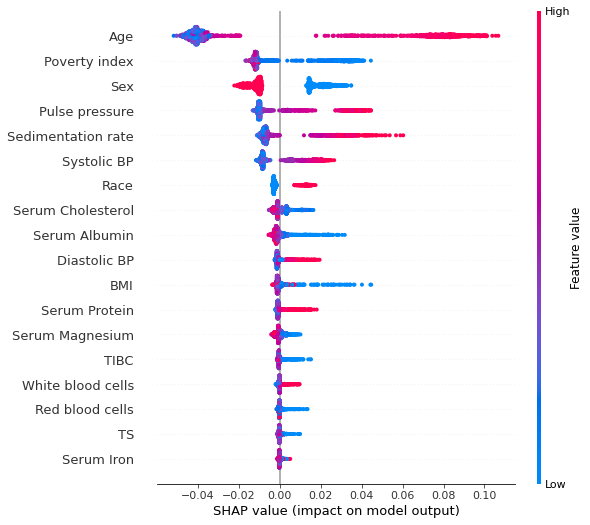

In [53]:
# 1 - male, 2 - female
shap.summary_plot(shap_values, X_test)

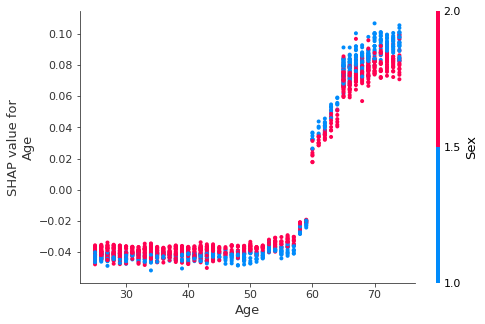

In [37]:
shap.dependence_plot('Age', shap_values, X_test, interaction_index='Sex')

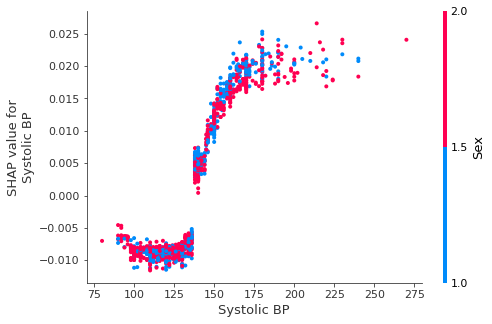

In [52]:
shap.dependence_plot('Systolic BP', shap_values, X_test, interaction_index='Sex')

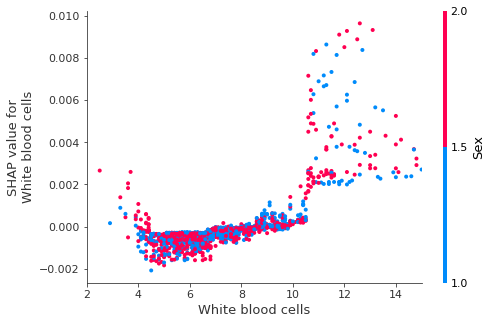

In [48]:
shap.dependence_plot('White blood cells', shap_values, X_test, interaction_index='Sex', show=False)
pl.xlim(2,15)
pl.show()

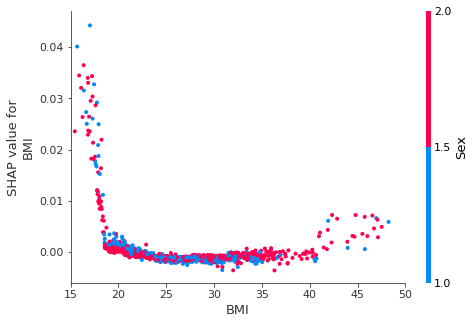

In [51]:
shap.dependence_plot('BMI', shap_values, X_test, interaction_index='Sex', show=False)
pl.xlim(15,50)
pl.show()

In [69]:
X,y = shap.datasets.nhanesi()